In [1]:
import numpy as np
from numpy.random import uniform
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader

In [2]:
def sinusoid(x, x0, A, B):
    y = A*np.sin(x0 + B*x)
    return y

def get_sample(x_dim):
    x0 = uniform(low = 0, high = 1)
    #A = uniform(low = 0.5, high = 0.8)
    A = 1
    B = uniform(low = 1.2, high = 1.5)
    sample = np.array([sinusoid(item, x0, A, B) for item in np.linspace(0, 6*np.pi, x_dim)])
    return sample

In [3]:
x_dim = 64
sample_size = 25
samples = np.stack([get_sample(x_dim) for idx in range(sample_size)])

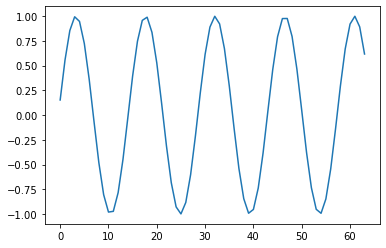

In [4]:
sample_idx = 0
plt.plot(samples[sample_idx]);

In [5]:
import torch
from torch import nn, optim, full, randn, no_grad
from tqdm.notebook import tqdm
import pandas as pd


class Generator(nn.Module):
    def __init__(self, dimLatent):
        super(Generator, self).__init__()
        self.dimLatent = dimLatent
        self.model = nn.Sequential(
            # 1st layer
            nn.Linear(in_features = self.dimLatent, out_features = 64),
            #nn.ReLU(),
            nn.LeakyReLU(),
            # 2nd layer
            nn.Linear(in_features = 64, out_features = 128),
            #nn.ReLU(),
            nn.LeakyReLU(),
            # 3rd layer
            nn.Linear(in_features = 128, out_features = 64),
            nn.Tanh()
        )
    
    def forward(self, noise):
        x = self.model(noise)
        return x


class Discriminator(nn.Module):
    def __init__(self, featureCount):
        super(Discriminator, self).__init__()
        self.featureCount = featureCount
        self.model = nn.Sequential(
            # 1st layer
            nn.Linear(in_features = self.featureCount, out_features = 128),
            nn.LeakyReLU(),
            # 2nd layer
            nn.Linear(in_features = 128, out_features = 64),
            nn.LeakyReLU(),
            # 3rd layer
            nn.Linear(in_features = 64, out_features = 1),
            nn.Sigmoid()
        )
    
    def forward(self, data):
        bool_ = self.model(data)
        return bool_


class GAN(object):
    def __init__(self, device, dataLoader, dimLatent, featureCount, lr, epochCount):
        self.device = device
        self.dataLoader = dataLoader
        self.dimLatent = dimLatent
        self.featureCount = featureCount
        self.lr = lr
        self.epochCount = epochCount

        # Initialize generator
        self.Gen = Generator(dimLatent)
        self.Gen.to(self.device)

        # Initialize discriminator
        self.Dis = Discriminator(featureCount)
        self.Dis.to(self.device)
    
        # Initialize optimizers
        self.optimGen = optim.Adam(params = self.Gen.parameters(), lr = self.lr)
        self.optimDis = optim.Adam(params = self.Dis.parameters(), lr = self.lr)

        # Initialize the loss function
        self.criterion = nn.BCELoss()

        self.df_loss = pd.DataFrame(columns = ['epoch', 'batch index', 'discriminator loss', 'generator loss'])
        self.iterCount = 0
        self.noiseFixed = randn(featureCount, dimLatent, device = device)
    
    def train(self):
        for epoch in tqdm(range(self.epochCount)):
            for batchIdx, data in enumerate(self.dataLoader):
                data = data.to(device = self.device, dtype = torch.float32)

                # Train discriminator with real data
                self.Dis.zero_grad()                                                                                    #set the gradients to zero for every mini-batch
                yReal = self.Dis(data)                                                                                  #train discriminator with real data
                labelReal = full(size = (data.size(0), 1), fill_value = 1, device = self.device, dtype = torch.float32) #a tensor containing only ones
                lossDisReal = self.criterion(yReal, labelReal)                                                          #calculate the loss
                lossDisReal.backward()                                                                                  #calculate new gradients

                # Train discriminator with fake data
                noise = randn(data.size(0), self.dimLatent, device = self.device)                                       #create a tensor filled with random numbers
                labelFake = full(size = (data.size(0), 1), fill_value = 1, device = self.device, dtype = torch.float32) #a tensor containing only zeros
                xFake = self.Gen(noise)                                                                                 #create fake data from noise with generator
                yFake = self.Dis(xFake.detach())                                                                        #let the discriminator label the fake data (`.detach()` creates a copy of the tensor)
                lossDisFake = self.criterion(yFake, labelFake)
                lossDisFake.backward()

                lossDis = (lossDisReal + lossDisFake)                                                                   #compute the total discriminator loss
                self.optimDis.step()                                                                                    #update the discriminator

                # Train generator (now that we fed the discriminator with fake data)
                self.Gen.zero_grad()
                yFake_2 = self.Dis(xFake)                                                                               #let the discriminator label the fake data (now that the discriminator is updated)
                lossGen = self.criterion(yFake_2, labelReal)                                                            #calculate the generator loss (small if the discriminator thinks that `yFake_2 == labelReal`)
                lossGen.backward()
                self.optimGen.step()

                # Log the progress
                self.df_loss.loc[len(self.df_loss)] = [epoch, batchIdx, lossDis.detach().numpy(), lossGen.detach().numpy()]
                if self.iterCount % 500 == 0:
                    with no_grad():
                        dataFake = self.Gen(self.noiseFixed).detach().numpy()
                        plt.plot(dataFake[1])
                        plt.show();
                self.iterCount += 1

  0%|          | 0/50 [00:00<?, ?it/s]

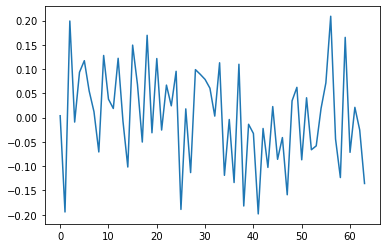

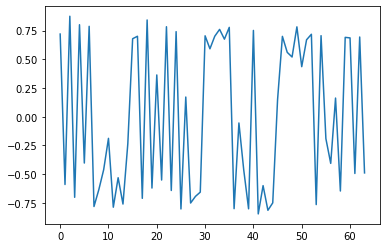

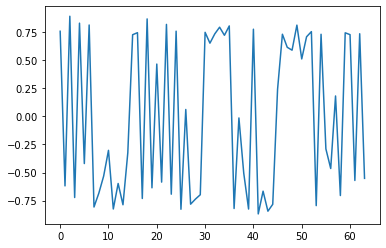

In [6]:
#device = torch.device('cuda:0')
device = torch.device('cpu')
dataLoader = DataLoader(samples)
dimLatent = 8
featureCount = samples.shape[1]
lr = 1e-4
epochCount = 50

model = GAN(device, dataLoader, dimLatent, featureCount, lr, epochCount)
model.train()

In [9]:
model.df_loss

,epoch,batch index,discriminator loss,generator loss
0,0,0,1.1952305,0.621736
1,0,1,1.1931365,0.61939335
2,0,2,1.194697,0.6281571
3,0,3,1.2381387,0.62683356
4,0,4,1.1731803,0.62037235
...,...,...,...,...
1245,49,20,0.00035719987,4.8280926e-05
1246,49,21,0.0001882461,1.8000765e-05
1247,49,22,0.0012939833,0.00019522426
1248,49,23,0.00033673501,0.00016178009


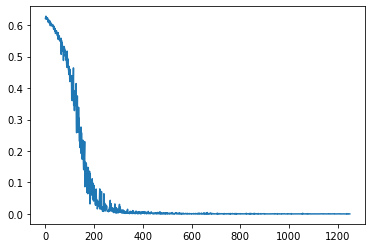

In [7]:
plt.plot(model.df_loss['generator loss'])

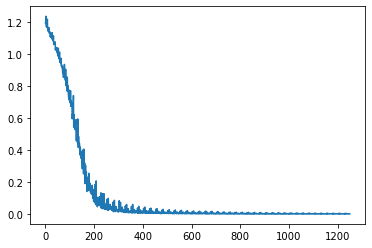

In [8]:
plt.plot(model.df_loss['discriminator loss'])